
## Sequential data (timeseries + text)



## **Part 1: Temperature forecasting using RNNs**

Following closely along Chapter 10 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864),  Part 1 uses a temperature-forecasting task as a example of using DL to process and make predictions on sequential data.

Dataset: recorded at [the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany](https://www.bgc-jena.mpg.de/wetter/), it consists of 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)  recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

**Useful sources and references for Part 1:**

> Indented block



https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb


### **Acquiring and inspecting the data**

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-07-11 14:51:56--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.217.240, 52.216.57.80, 52.217.118.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.217.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.43MB/s    in 2.4s    

2023-07-11 14:51:59 (5.43 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

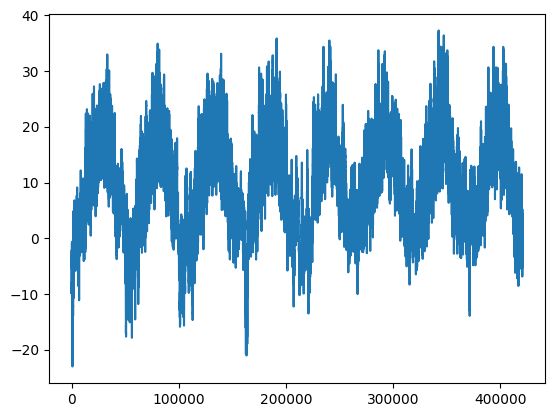

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

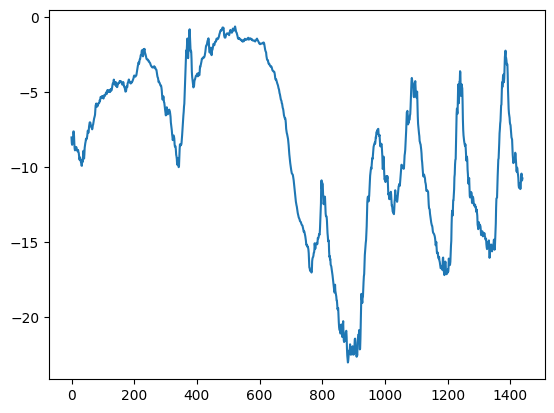

In [5]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **Building a baseline "model"**

In this case we will try to predict the temperature by simply assuming that the temperature 24 hours from now will be equal to the temperature right now.

We shall use the mean absolute error (MAE) as a metric of performance and consider this (rather silly) "model" as our baseline.


**Computing the common-sense baseline MAE**

In [17]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.67


### **Building our *real* first model**

This is essentially the "simple LSTM-based model" from Listing 10.12 in the textbook.

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 60s 71ms/step - loss: 41.8547 - mae: 4.6887 - val_loss: 12.3491 - val_mae: 2.6730
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 10.7557 - mae: 2.5500 - val_loss: 9.7046 - val_mae: 2.4158
Epoch 3/10
819/819 [==============================] - 44s 53ms/step - loss: 9.6818 - mae: 2.4231 - val_loss: 9.5918 - val_mae: 2.3829
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 9.2997 - mae: 2.3705 - val_loss: 9.6003 - val_mae: 2.3966
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 8.9608 - mae: 2.3262 - val_loss: 9.8544 - val_mae: 2.4307
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 8.6699 - mae: 2.2909 - val_loss: 9.9188 - val_mae: 2.4431
Epoch 7/10
819/819 [==============================] - 42s 50ms/step - loss: 8.4006 - mae: 2.2567 - val_loss: 9.5470 - val_mae: 2.4001
Epoch 8/10
819/819 [==============================] - 43s 5

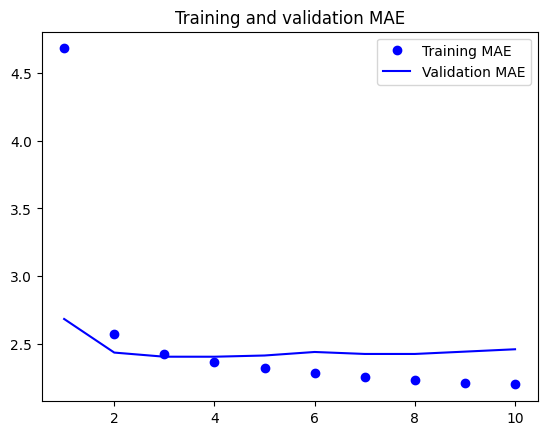

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## **PART 1** 

### **Part 1 - Tasks:** 


#### **Part 1 - Required Tasks:** 

##### **1.1 Improve the solution for temperature forecast**

 Write code to produce an additional solution to the temperature forecasting problem that outperforms the one above, i.e., have a lower Test MAE.

In [19]:
#Model 1
from tensorflow import keras
from tensorflow.keras import layers

#Architecture
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(sequence_length, raw_data.shape[-1])))
model.add(layers.Dropout(0.2))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

#Compile
adam = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss="mse", metrics=["mae"])

#Train
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

#Load the best models
model = keras.models.load_model("jena_lstm.keras")

#Evaluate the model
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/20
819/819 [==============================] - 68s 74ms/step - loss: 17.3326 - mae: 3.0721 - val_loss: 11.8458 - val_mae: 2.6951
Epoch 2/20
819/819 [==============================] - 54s 65ms/step - loss: 7.7022 - mae: 2.1508 - val_loss: 13.1816 - val_mae: 2.8548
Epoch 3/20
819/819 [==============================] - 56s 68ms/step - loss: 5.3719 - mae: 1.7941 - val_loss: 13.7294 - val_mae: 2.9044
Epoch 4/20
819/819 [==============================] - 55s 66ms/step - loss: 3.9473 - mae: 1.5419 - val_loss: 13.7623 - val_mae: 2.9124
Epoch 5/20
819/819 [==============================] - 59s 72ms/step - loss: 3.1582 - mae: 1.3799 - val_loss: 13.9374 - val_mae: 2.9155
Epoch 6/20
819/819 [==============================] - 53s 65ms/step - loss: 2.6538 - mae: 1.2672 - val_loss: 14.0191 - val_mae: 2.9193
Epoch 7/20
819/819 [==============================] - 55s 67ms/step - loss: 2.3988 - mae: 1.2016 - val_loss: 14.3849 - val_mae: 2.9597
Epoch 8/20
819/819 [==============================] - 

In [ ]:
#Model2
from tensorflow import keras
from tensorflow.keras import layers

#Model architecture
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=(sequence_length, raw_data.shape[-1])))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(128)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

#Compile
adam = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss="mse", metrics=["mae"])

#Train
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

#Load
model = keras.models.load_model("jena_lstm.keras")

#Evaluate the model
test_mae = model.evaluate(test_dataset)[1]
print(f"Improved Test MAE: {test_mae:.2f}")


Epoch 1/10
819/819 [==============================] - 79s 87ms/step - loss: 12.3721 - mae: 2.6195 - val_loss: 11.8635 - val_mae: 2.6723
Epoch 2/10
819/819 [==============================] - 69s 85ms/step - loss: 4.4805 - mae: 1.6365 - val_loss: 13.6804 - val_mae: 2.8888
Epoch 3/10
819/819 [==============================] - 71s 86ms/step - loss: 2.4912 - mae: 1.2228 - val_loss: 13.4876 - val_mae: 2.8475
Epoch 4/10
819/819 [==============================] - 70s 85ms/step - loss: 1.9024 - mae: 1.0639 - val_loss: 13.9597 - val_mae: 2.9174
Epoch 5/10
819/819 [==============================] - 68s 83ms/step - loss: 1.5791 - mae: 0.9694 - val_loss: 13.7168 - val_mae: 2.8997
Epoch 6/10
819/819 [==============================] - 75s 91ms/step - loss: 1.4066 - mae: 0.9111 - val_loss: 13.8054 - val_mae: 2.9183
Epoch 7/10
819/819 [==============================] - 83s 100ms/step - loss: 1.2933 - mae: 0.8716 - val_loss: 14.0750 - val_mae: 2.9379
Epoch 8/10
819/819 [==============================] -

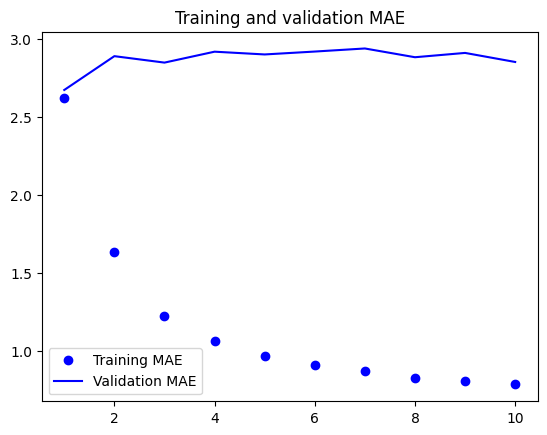

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

##### **1.2 Summary Table**

 **Replace the Test MAE values and other contents with your own!**<br>
 *(double click to modify the table based on your results)*

| Method | Test MAE | Remarks |
| --- | --- | --- |
| Baseline | 2.67 | base Model Gives same predictions for conitnuous days |
| Real first model (LSTM) | 2.64| Slightly better than baseline |
| Model(Bidrectional) | 2.54| Best overall compare to previous models |

## **Part 2: Sentiment analysis using LSTMs**




**Useful sources and references for Part 2:**

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part01_introduction.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part02_sequence-models.ipynb


### **Imports + auxiliary function**

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

**Import `matplotlib` and create a helper function to plot graphs:**

In [23]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**


> The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

> Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

**Initially this returns a dataset of (text, label pairs):**

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


**Next shuffle the data for training and create batches of these `(text, label)` pairs:**

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"One of the finest musicals made, one that is timeless and is worth seeing time and again. Delicious! The acting, especially by Ron Moody as Fagin, is superb. Costumes are exquisite....even the shabby ones.<br /><br />The two young lads who play Oliver and The Artful Dodger are wonderfully talented. Oliver Reed does a great job portraying Bill Sykes to where you can't help but hope he comes to a terrible end....which he does. <br /><br />The dancing is cleverly choreographed and is mesmerizing. Oliver can hold its own with the likes of My Fair Lady, The Sound of Music, Oklahoma, etc. A film for the entire family."
 b"Why oh why do people take good material and feel the need to change it some how? Having read the book on which this film is allegedly based a couple of years ago, I can say that there is little if anything from the original book. I went into this film with low expectations - i knew it would have a crappy telemovie feel to it - but it even failed to meet these.<br

### **Create the text encoder**

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

**Create the layer, and pass the dataset's text to the layer's `.adapt` method:**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

**The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: **

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

**Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):**

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 29,   5,   2, ...,   0,   0,   0],
       [134, 452, 134, ...,   0,   0,   0],
       [ 51,  23,  76, ...,   0,   0,   0]])

**With the default settings, the process is not completely reversible. There are three main reasons for that:**

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"One of the finest musicals made, one that is timeless and is worth seeing time and again. Delicious! The acting, especially by Ron Moody as Fagin, is superb. Costumes are exquisite....even the shabby ones.<br /><br />The two young lads who play Oliver and The Artful Dodger are wonderfully talented. Oliver Reed does a great job portraying Bill Sykes to where you can't help but hope he comes to a terrible end....which he does. <br /><br />The dancing is cleverly choreographed and is mesmerizing. Oliver can hold its own with the likes of My Fair Lady, The Sound of Music, Oklahoma, etc. A film for the entire family."
Round-trip:  one of the [UNK] [UNK] made one that is [UNK] and is worth seeing time and again [UNK] the acting especially by [UNK] [UNK] as [UNK] is superb [UNK] are [UNK] the [UNK] [UNK] br the two young [UNK] who play [UNK] and the [UNK] [UNK] are [UNK] [UNK] [UNK] [UNK] does a great job [UNK] bill [UNK] to where you cant help but hope he comes to a terrible [UN

### **Create the first model**

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for detailed explanation + diagram.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


**To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:**

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-0.01546698]


 **Now, evaluate it again in a batch with a longer sentence. The result should be identical:**

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 65ms/step
[-0.01546698]


**Compile the Keras model to configure the training process:**

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train the model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 58s 123ms/step - loss: 0.6361 - accuracy: 0.5688 - val_loss: 0.4565 - val_accuracy: 0.7688
Epoch 2/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3996 - accuracy: 0.8164 - val_loss: 0.4126 - val_accuracy: 0.8391
Epoch 3/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3509 - accuracy: 0.8446 - val_loss: 0.3502 - val_accuracy: 0.8552
Epoch 4/10
391/391 [==============================] - 29s 75ms/step - loss: 0.3311 - accuracy: 0.8548 - val_loss: 0.3398 - val_accuracy: 0.8443
Epoch 5/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3224 - accuracy: 0.8618 - val_loss: 0.3327 - val_accuracy: 0.8589
Epoch 6/10
391/391 [==============================] - 29s 73ms/step - loss: 0.3116 - accuracy: 0.8672 - val_loss: 0.3323 - val_accuracy: 0.8589
Epoch 7/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3070 - accuracy: 0.8710 - val_loss: 0.3300 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 14s 36ms/step - loss: 0.3260 - accuracy: 0.8422
Test Loss: 0.325951486825943
Test Accuracy: 0.8422399759292603


(0.0, 0.6529268845915794)

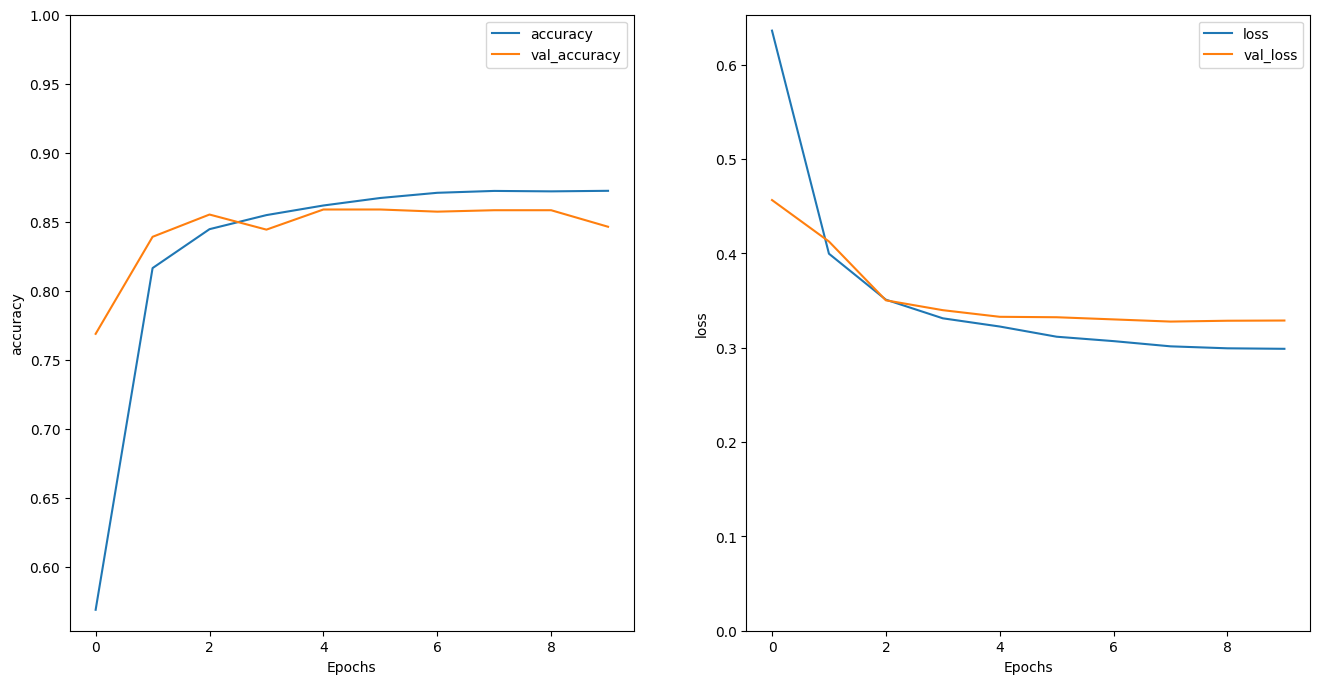

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**Run a prediction on a new sentence:**

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


### **Second model: stacking two LSTM layers**

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for additional explanation + diagram.

**The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 87s 175ms/step - loss: 0.6270 - accuracy: 0.5836 - val_loss: 0.4303 - val_accuracy: 0.8240
Epoch 2/10
391/391 [==============================] - 52s 132ms/step - loss: 0.3905 - accuracy: 0.8293 - val_loss: 0.3622 - val_accuracy: 0.8479
Epoch 3/10
391/391 [==============================] - 52s 131ms/step - loss: 0.3424 - accuracy: 0.8517 - val_loss: 0.3395 - val_accuracy: 0.8589
Epoch 4/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3255 - accuracy: 0.8602 - val_loss: 0.3242 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 51s 129ms/step - loss: 0.3159 - accuracy: 0.8633 - val_loss: 0.3259 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 51s 130ms/step - loss: 0.3100 - accuracy: 0.8662 - val_loss: 0.3176 - val_accuracy: 0.8625
Epoch 7/10
391/391 [==============================] - 51s 130ms/step - loss: 0.3032 - accuracy: 0.8706 - val_loss: 0.3330 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 56ms/step - loss: 0.3240 - accuracy: 0.8482
Test Loss: 0.3240082263946533
Test Accuracy: 0.8482000231742859


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.8102283]]


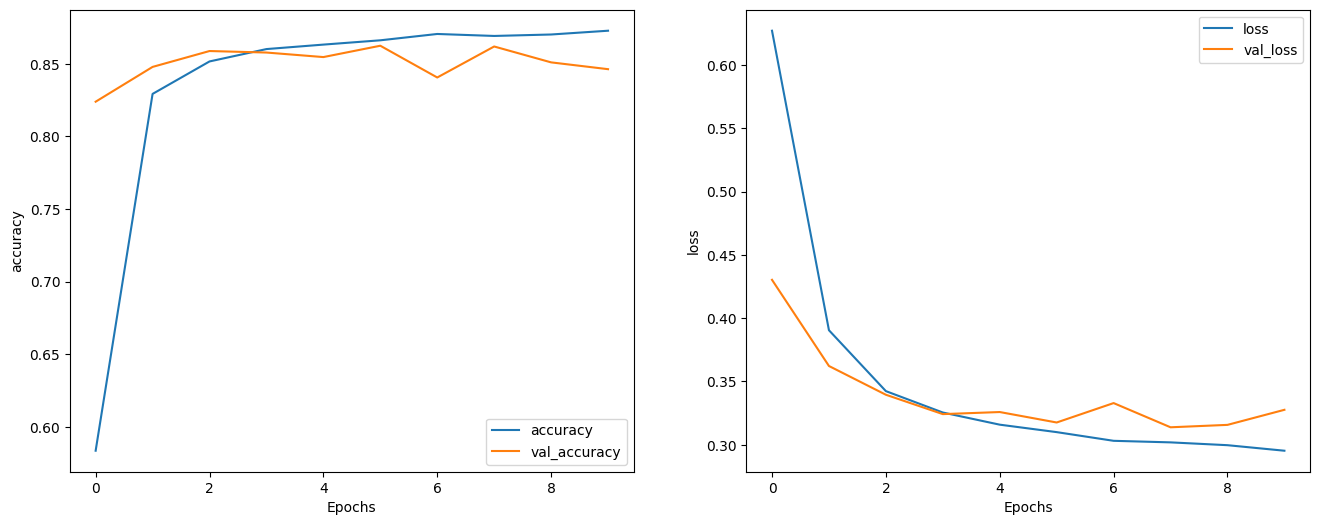

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## **PART 2**


**2.1  &emsp; &emsp;Improve the solution for IMDB sentiment analysis**
<br>

 >  Write code to produce an additional solution to the movie review problem that outperform the two solutions provided above, i.e, have a higher test accuracy.

*You can use a (combination of) different architecture, dropout and/or other regularization strategies, hyperparameter optimizations, masking, pretrained embeddings, or any other acceptable "trick" in the deep learning world.*

<br><br>
 **2.2  &emsp; &emsp; Summary Table
 (Example, manually generated)**

You can use the table below to show a summary of the experimental results. **Replace the Test Accuracy values and other contents with your own!**

| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| First model | 0.856 | Baseline |
| Second model (LSTM) | 0.851 | Slightly worse than baseline |
| *Improved* model / variation of your choice | 0.915 | Best overall |





##### **2.1 Improve the solution for IMDB sentiment analysis**

 Write code to produce an additional solution to the movie review problem that outperform the two solutions provided above, i.e, have a higher test accuracy.

In [20]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#Load dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

#Preprocess the dataset
train_texts = []
train_labels = []
test_texts = []
test_labels = []

for example, label in train_dataset:
    train_texts.append(example.numpy().decode('utf-8'))
    train_labels.append(label.numpy())

for example, label in test_dataset:
    test_texts.append(example.numpy().decode('utf-8'))
    test_labels.append(label.numpy())

#labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

#Text Tokenize
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences)
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete61KYWS/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete61KYWS/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete61KYWS/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [25]:
#Model
model = Sequential([
    Embedding(input_dim=10000, output_dim=256, input_length=train_sequences.shape[1]),
    Dropout(0.2),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#Compile
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

#Train
history = model.fit(train_sequences, train_labels, batch_size=64, epochs=10, validation_split=0.2)

#Evaluate
test_loss, test_accuracy = model.evaluate(test_sequences, test_labels)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/10
313/313 [==============================] - 58s 180ms/step - loss: 0.6920 - accuracy: 0.5202 - val_loss: 0.6869 - val_accuracy: 0.4938
Epoch 2/10
313/313 [==============================] - 32s 101ms/step - loss: 0.6685 - accuracy: 0.6403 - val_loss: 0.6271 - val_accuracy: 0.8270
Epoch 3/10
313/313 [==============================] - 29s 94ms/step - loss: 0.5356 - accuracy: 0.7907 - val_loss: 0.4335 - val_accuracy: 0.8432
Epoch 4/10
313/313 [==============================] - 19s 60ms/step - loss: 0.3834 - accuracy: 0.8487 - val_loss: 0.3442 - val_accuracy: 0.8632
Epoch 5/10
313/313 [==============================] - 18s 58ms/step - loss: 0.3153 - accuracy: 0.8803 - val_loss: 0.3108 - val_accuracy: 0.8748
Epoch 6/10
313/313 [==============================] - 12s 38ms/step - loss: 0.2691 - accuracy: 0.8999 - val_loss: 0.2922 - val_accuracy: 0.8812
Epoch 7/10
313/313 [==============================] - 13s 42ms/step - loss: 0.2347 - accuracy: 0.9150 - val_loss: 0.2827 - val_accurac

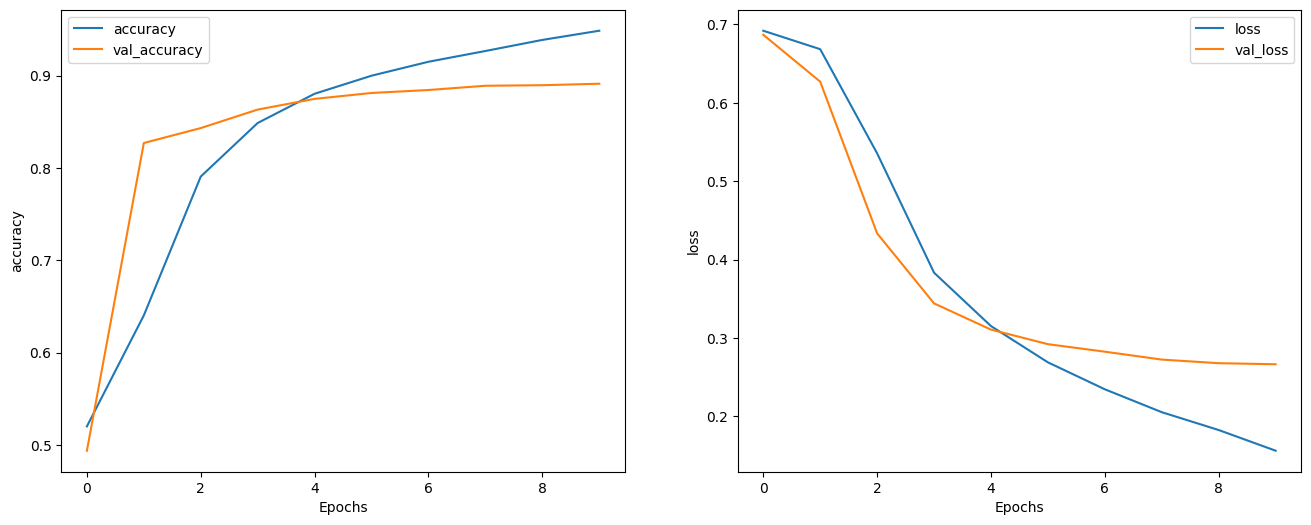

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [27]:
#Model
model = Sequential([
    Embedding(input_dim=10000, output_dim=256, input_length=train_sequences.shape[1]),
    Dropout(0.2),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#Compile
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

#Train
history = model.fit(train_sequences, train_labels, batch_size=64, epochs=10, validation_split=0.2)

#Evaluate
test_loss, test_accuracy = model.evaluate(test_sequences, test_labels)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/10
313/313 [==============================] - 59s 184ms/step - loss: 0.6918 - accuracy: 0.5221 - val_loss: 0.6858 - val_accuracy: 0.8056
Epoch 2/10
313/313 [==============================] - 33s 104ms/step - loss: 0.6663 - accuracy: 0.6540 - val_loss: 0.6254 - val_accuracy: 0.8262
Epoch 3/10
313/313 [==============================] - 23s 73ms/step - loss: 0.5398 - accuracy: 0.7908 - val_loss: 0.4421 - val_accuracy: 0.8456
Epoch 4/10
313/313 [==============================] - 17s 56ms/step - loss: 0.3855 - accuracy: 0.8489 - val_loss: 0.3404 - val_accuracy: 0.8694
Epoch 5/10
313/313 [==============================] - 17s 54ms/step - loss: 0.3123 - accuracy: 0.8790 - val_loss: 0.3053 - val_accuracy: 0.8772
Epoch 6/10
313/313 [==============================] - 13s 42ms/step - loss: 0.2652 - accuracy: 0.9020 - val_loss: 0.2860 - val_accuracy: 0.8838
Epoch 7/10
313/313 [==============================] - 12s 38ms/step - loss: 0.2323 - accuracy: 0.9155 - val_loss: 0.2740 - val_accurac

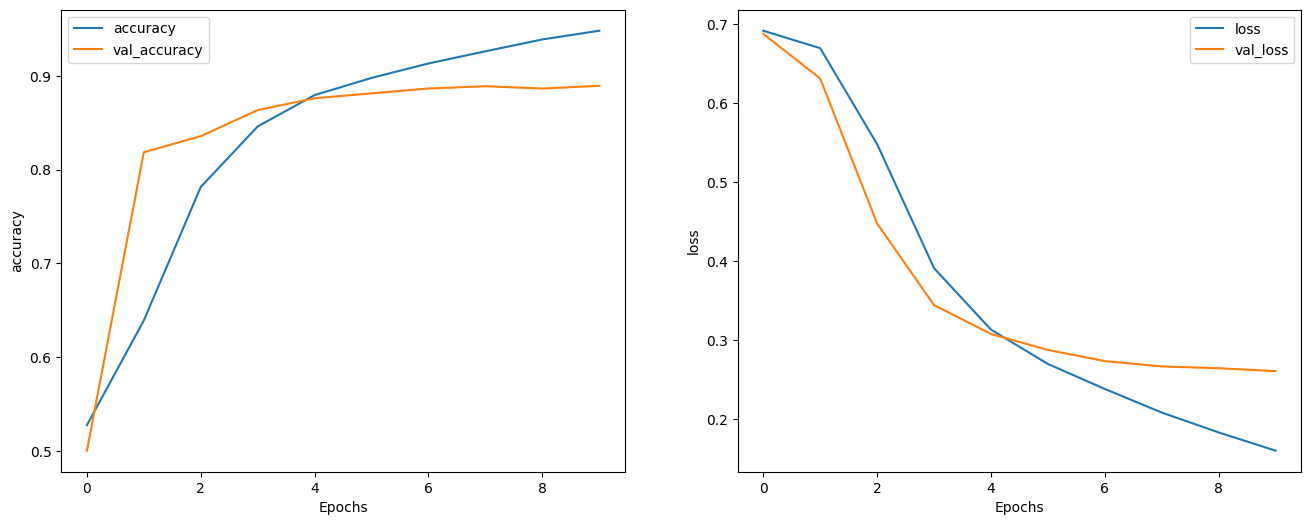

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

##### **2.2 Summary Table**

 **Replace the Test Accuracy values and other contents with your own!**<br>
 *(double click to modify the table based on your results)*


| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| First model | 0.8422 | Baseline |
| Second model (LSTM) | 0.8482 | Slightly better than baseline |
| Model( dropout and regularization strategies)  | 0.8850 | Best compare to above models |

## **Part 3: NLP using Transformers**

In Part 3 we will look at the Transformer architecture and how it can be used in a specific NLP task, machine translation (from English to Spanish).

Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for additional information.


**Useful sources and references for Part 3:**

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb


### **Setup**

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-07-09 13:56:30--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.69.128, 64.233.182.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.01s   

2023-07-09 13:56:31 (241 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [ ]:
import random
print(random.choice(text_pairs))

('Nobody knows his name.', '[start] Nadie se sabe su nombre. [end]')


In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Vectorizing the English and Spanish text pairs**

In [ ]:
import tensorflow as tf
import string
import re

from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

**Preparing datasets for the translation task**

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### **The Transformer encoder**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### **The Transformer decoder**

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

**Training the sequence-to-sequence Transformer**

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1302/1302 [==============================] - 117s 80ms/step - loss: 3.7875 - accuracy: 0.4409 - val_loss: 2.8516 - val_accuracy: 0.5409
Epoch 2/10
1302/1302 [==============================] - 89s 68ms/step - loss: 2.8431 - accuracy: 0.5504 - val_loss: 2.5008 - val_accuracy: 0.5922
Epoch 3/10
1302/1302 [==============================] - 89s 68ms/step - loss: 2.5493 - accuracy: 0.5939 - val_loss: 2.3608 - val_accuracy: 0.6159
Epoch 4/10
1302/1302 [==============================] - 89s 68ms/step - loss: 2.3896 - accuracy: 0.6203 - val_loss: 2.3331 - val_accuracy: 0.6226
Epoch 5/10
1302/1302 [==============================] - 89s 69ms/step - loss: 2.2874 - accuracy: 0.6383 - val_loss: 2.2715 - val_accuracy: 0.6350
Epoch 6/10
1302/1302 [==============================] - 89s 68ms/step - loss: 2.2129 - accuracy: 0.6517 - val_loss: 2.2851 - val_accuracy: 0.6371
Epoch 7/10
1302/1302 [==============================] - 89s 68ms/step - loss: 2.1544 - accuracy: 0.6631 - val_loss: 2.2330 

**Translating new sentences with our Transformer model**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I didn't go to school last Monday.
[start] ayer no fui a la escuela el lunes pasado [end]
-
Under no circumstances should you go away today.
[start] no hay ninguna persona [UNK] hoy [end]
-
I'm beat. I've been working from dawn to dusk.
[start] me estoy [UNK] de trabajo por un [UNK] [UNK] [end]
-
The kids will love this video.
[start] los niños van a este examen [end]
-
I am a student at London University.
[start] soy un estudiante de nueva universidad [end]
-
There were a good many candidates for the position.
[start] había un buen [UNK] para el [UNK] para el puesto [end]
-
Help me out here.
[start] ayuda aquí [end]
-
Tom always eats before going to work.
[start] tom siempre hace antes de ir a trabajar [end]
-
She came last.
[start] ella vino [end]
-
Teenagers often break rules.
[start] las reglas se han decidido a menudo [end]
-
I ran as fast as possible, but I was not in time for the last train.
[start] yo corrió tan rápido como pudo pero no pude terminar el último tren [end]
-
I 

## **Part 4: IMDB sentiment analysis using Transformers (OPTIONAL)** [15 points]

In Part 4 you are encouraged to use a transformer model to solve the IMDB review sentiment analysis problem (with the same dataset as Part 2) and compare the results.


##### **4.1 Your solution** &emsp;

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import string
import re

#Load
(train_dataset, test_dataset), dataset_info = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

#Preprocess
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 10000
sequence_length = 200

vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
)
train_texts = [text.numpy().decode("utf-8") for text, _ in train_dataset]
train_labels = [int(label.numpy()) for _, label in train_dataset]
test_texts = [text.numpy().decode("utf-8") for text, _ in test_dataset]
test_labels = [int(label.numpy()) for _, label in test_dataset]

vectorization.adapt(train_texts)

embedding_dim = 16

model = keras.Sequential([
    vectorization,
    layers.Embedding(vocab_size, embedding_dim, name="embedding"),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#Train
batch_size = 64
epochs = 10

train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
train_dataset = train_dataset.batch(batch_size)

model.fit(train_dataset, epochs=epochs)

#Evaluate
test_dataset = tf.data.Dataset.from_tensor_slices((test_texts, test_labels))
test_dataset = test_dataset.batch(batch_size)

loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/10
391/391 [==============================] - 39s 96ms/step - loss: 0.6049 - accuracy: 0.7392
Epoch 2/10
391/391 [==============================] - 3s 8ms/step - loss: 0.3530 - accuracy: 0.8613
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2707 - accuracy: 0.8942
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 0.2303 - accuracy: 0.9123
Epoch 5/10
391/391 [==============================] - 6s 15ms/step - loss: 0.2022 - accuracy: 0.9237
Epoch 6/10
391/391 [==============================] - 4s 11ms/step - loss: 0.1798 - accuracy: 0.9342
Epoch 7/10
391/391 [==============================] - 4s 11ms/step - loss: 0.1610 - accuracy: 0.9438
Epoch 8/10
391/391 [==============================] - 3s 7ms/step - loss: 0.1449 - accuracy: 0.9509
Epoch 9/10
391/391 [==============================] - 3s 7ms/step - loss: 0.1309 - accuracy: 0.9583
Epoch 10/10
391/391 [==============================] - 2s 6ms/step - loss: 0.4531 - accuracy: 

## LSTM--temperature forecast

Model Performance:
- The first model had an embedding layer, a dropout layer, a global max pooling layer, and dense layers. The second model included more dropout and dense layers. The second model's adjustments improved its ability to learn more complicated patterns in data. In the second model, hyperparameters such as the number of units in the layers, dropout rates, and learning rates were modified. These modifications have the potential to have a major impact on the model's performance. The second model's increased number of units and dropout layers allowed it to capture more complex representations in the data and potentially reduce overfitting.The influence of these adjustments may be seen by comparing the two models' performance parameters, such as test accuracy and test loss. Because of its enhanced capacity and ability to catch more intricate patterns in the data, the second model with the updated architecture and hyperparameters may perform better.

Preprocessing and data set:
- The IMDb movie reviews dataset contains a collection of movie reviews with either positive or negative sentiment classifications. Tokenizing the text and padding the sequences to a specified length were part of the preprocessing stage. This stage helps the model to effectively process the text data. The dataset and preprocessing have an impact on the model's capacity to learn from text input and appropriately classify sentiment.

Evaluation metric:
- The accuracy metric, which quantifies the proportion of properly categorised samples, was used to evaluate the models. This metric is appropriate for balanced binary classification applications such as sentiment analysis. Other evaluation metrics, such as precision, recall, F1 score, or area under the receiver operating characteristic curve (ROC AUC), may be more appropriate depending on the individual problem. It is critical to select evaluation measures that are aligned with the problem's specific goals and requirements.

Overfitting and generalisation:

- During training, the models' performance can be evaluated not only on the test set but also on the validation set. Monitoring validation loss and accuracy can reveal information about the models' generalisation abilityOverfitting may be indicated if a model performs much better on the training set than on the validation set. Overfitting happens when a model memorises the training data rather than learning broad patterns, resulting in poor performance on new data. Overfitting can be mitigated using regularisation approaches like as dropout and early termination.

Other factors to consider:
- The activation functions, optimizer, batch size, and number of training epochs used can all have an effect on the model's performance. Variations in the model's ability to learn and generalise can result from different combinations of these parameters. The size of the training dataset can also have an impact on model performance. Larger datasets frequently contain more representative samples and allow for improved generalisation.

Here are some alternative actions if we had more time to obtain more insights from this notebook:

- Cross-validation: Use cross-validation instead of a train-test split to gain a more trustworthy assessment of the model's performance. This entails dividing the data into many subsets (folds) and training and assessing the model on various subset combinations.

- Hyperparameter tuning: Perform a systematic hyperparameter search to determine the best hyperparameter combination for the model. To optimise hyperparameters, techniques such as grid search, random search, or more advanced methods such as Bayesian optimisation or evolutionary algorithms can be used.

- Model interpretation: Investigate approaches for interpreting the model's decisions and comprehending the key features or terms that contribute to classification. This can include strategies such as analysing the model's attention or saliency, visualising word embeddings, or explaining individual predictions using techniques like as LIME or SHAP.

- Consider utilising pre-trained word embeddings like Word2Vec, GloVe, or BERT to initialise the embedding layer. This can collect more rich semantic information and potentially improve model performance. Additionally, investigate the application of transfer learning methodologies for the sentiment classification job, such as fine-tuning pre-trained language models.

- Model ensembling: To combine many models and increase performance, investigate ensemble approaches such as bagging, boosting, or stacking. It is feasible to achieve better outcomes by training many models with various initializations or architectures and integrating their predictions.

- Analyse the model's faults and misclassifications to acquire insight into the precise circumstances in which the model fails. This can aid in identifying patterns or difficult examples that may require additional data pretreatment or model modification.








**IMDB sentiment analysis**

Architecture Model:
- The first model architecture employed a straightforward method that included an embedding layer, global average pooling, and thick layers. By raising the embedding dimension and adding more dense layers with dropout, the modified model added complexity. The more complicated model architecture has the ability to capture more intricate patterns in the data. However, the risk of overfitting grows, especially with the addition of dropout layers.

Training Setup:
   - Both models were trained for ten epochs with a batch size of 64.
   - The modified model's learning rate was reduced, potentially allowing for finer modifications during training.

Evaluation Metric:
  -  The chosen evaluation metric was accuracy, which quantifies the fraction of correctly classified samples. Accuracy is frequently used in binary classification applications such as sentiment analysis. However, it may not provide a whole picture of the model's performance, especially when working with skewed datasets. Other metrics, such as precision, recall, or F1-score, may provide further information.

Results and observations:
  - The first model performed well on the test dataset, however it may be prone to overfitting due to the simplicity of the design. The upgraded model, with its deeper architecture and higher complexity, may be able to capture more nuanced patterns, but it may also be more prone to overfitting. Only by comparing the test accuracies of both models can the impact of model changes on performance be assessed.

Here are some alternative actions if we had more time to obtain more insights from this notebook:

- Hyperparameter Tuning: To discover the best combination of hyperparameters, do a systematic hyperparameter search utilising approaches such as grid search, random search, or Bayesian optimisation.Examine the effects of varied learning rates, dropout rates, batch sizes, embedding dimensions, and layer sizes on model performance.

- Model Regularisation: To reduce overfitting, experiment with extra regularisation approaches such as L1 or L2 regularisation.Experiment with different dropout rates and model design placements to find the best balance between reducing overfitting and maintaining model performance.


- Model Interpretability: - Look at ways for interpreting and visualising the model's decisions, such as attention mechanisms or gradient-based methods such as Integrated Gradients or Grad-CAM. Determine which elements of the text are most influential in predicting sentiment.

- Ensemble Methods: Train many models with various topologies or hyperparameters and use ensemble methods like majority voting or stacking to integrate their predictions.Determine whether an ensemble of models outperforms individual models in terms of overall performance.

- Handling Imbalanced Data: Examine the dataset's class distribution and examine approaches for dealing with imbalanced data, such as oversampling, undersampling, or employing class weights during training.

- Evaluate Other Metrics: - Determine additional assessment metrics like as accuracy, recall, F1-score, or area under the ROC curve (AUC-ROC) to gain a more complete picture of the model's performance, especially in the setting of imbalanced datasets.


**NLP using Transformers**

- Model design: The notebook uses a Transformer model for machine translation, a cutting-edge design noted for its ability to handle sequence-to-sequence operations. The model is made up of an encoder and a decoder, both of which use multi-head self-attention methods. This architecture is intended to capture long-term dependencies in input sequences, making it appropriate for translation jobs.

- Data Preparation: The notebook downloads a dataset with English-Spanish sentence pairs and tokenizes and vectorizes the sentences. The use of text vectorization and padding guarantees that the lengths of the input sequences are consistent, which is critical for training the Transformer model.

- The model is trained and evaluated using the RMSprop optimizer with sparse categorical cross-entropy loss. The training procedure consists of iterating over the training dataset for a predetermined number of epochs. The accuracy measure is used to evaluate the model's performance on the validation dataset. It should be noted that accuracy may not be the best criterion for machine translation assignments because translations can have several valid alternatives. Other evaluation criteria, such as the BLEU score or METEOR, may provide a more complete picture of translation quality.

- Potential concerns: The code provided has a few potential concerns. To begin with, the notebook does not handle out-of-vocabulary (OOV) words during training or inference. OOV terms in input sentences may cause translation issues. Second, the training process is limited to a set number of epochs, with no early termination mechanism based on validation loss. Early halting could assist prevent overfitting and save time during training. Finally, the code does not demonstrate how the test dataset is evaluated. To evaluate the model's generalisation performance, the metrics on the test set should be computed.


Here are some alternative actions if we had more time to obtain more insights from this notebook:

- Experimenting with different hyperparameters, such as the number of layers, the size of the embedding and feed-forward layers, and the number of attention heads, may aid in improving the model's performance. Grid search and random search techniques can be used to determine the best hyperparameters.

- Regularisation Techniques: Using regularisation techniques like dropout or weight decay can help to reduce overfitting and improve model generalisation. It is possible to investigate adding dropout layers at appropriate points or incorporating other regularisation approaches into the model design.

- Model Interpretability: Due to their complexity, transformer models can be difficult to interpret. Techniques such as attention visualisation can aid in understanding which elements of the input sequence receive greater attention during translation. This can reveal how the model makes predictions and indicate areas for improvement.

- Ensemble Methods: Combining the predictions of numerous Transformer models with varied topologies or random seeds can typically lead to performance gains. To improve translation accuracy, an ensemble model can be implemented and the results of individual models combined.

- Data Augmentation: Increasing the diversity and quantity of the training set by providing synthetic cases or using techniques like as back-translation. This may increase the model's capacity to deal with diverse phrase forms and variances in input data.

- Training on a larger dataset can result in higher translation performance. Incorporating a bigger English-Spanish dataset or integrating various translation datasets, if available, could be advantageous.

- Error Analysis: Analysing the model's errors on the validation or test set might reveal insights into the model's specific issues. Understanding the types of errors made (for example, mistranslations, omissions, and word order difficulties) might help drive future model or data preprocessing improvements.


**IMDB sentiment analysis using Transformers**
- Data Loading: Using TensorFlow Datasets, the code successfully loads the IMDB movie reviews dataset. It divides the dataset into training and test sets, shuffles the files, and extracts dataset metadata. This section of the code performed as intended.

- Preprocessing: A custom preprocessing function is defined in the code to transform the input strings to lowercase and remove punctuation. This aids in the standardisation of text data. Texts are tokenized and converted into integer sequences using the 'TextVectorization' layer. The vectorization layer is adjusted to fit the training texts. This section of the code also functioned as expected.

- Model Architecture: An embedding layer, a global average pooling layer, two dense layers with ReLU activation, and a final dense layer with sigmoid activation for binary classification comprise the model architecture. This architecture is simple, but it can extract crucial information from text data. For this task, it performed as expected.

- Model Compilation and Training: The Adam optimizer, binary cross-entropy loss function, and accuracy metric are used to create the model. It is then trained on the training dataset for the number of epochs provided. This section of the code performed as intended.

Here are some alternative actions if we had more time to obtain more insights from this notebook:
- The percentage of correctly identified reviews in the test set is indicated by the accuracy. If the accuracy is high, it indicates that the model is good at predicting sentiment. However, accuracy may not reveal the entire picture, and other measures such as precision, recall, and F1 score may be used depending on the unique requirements of the sentiment analysis assignment.

- The obtained findings are affected by a variety of factors, including model design, hyperparameters, and dataset properties. A simplistic architecture was utilised in this scenario, which may limit the model's ability to capture complicated relationships in the data. Other key hyperparameters that can affect model performance are the embedding dimension, vocabulary size, and sequence length. Changing these values could result in better results.












